# Data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
# Load the Dataset
df = pd.read_csv("credit_risk.csv")
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [3]:
# Basic Info

# Dataset shape
print("Shape:", df.shape)

# Data types and missing values
print("\nInfo:")
print(df.info())

# Summary statistics
print("\nDescribe:")
print(df.describe(include='all').T)

Shape: (1000, 21)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non

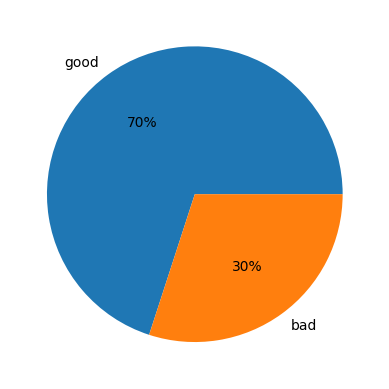

class
good    700
bad     300
Name: count, dtype: int64


In [4]:
# Target Variable Analysis
df["class"].value_counts().plot.pie(autopct="%1.0f%%")
plt.ylabel("")
plt.show()

# Print class balance ratio
print(df["class"].value_counts())


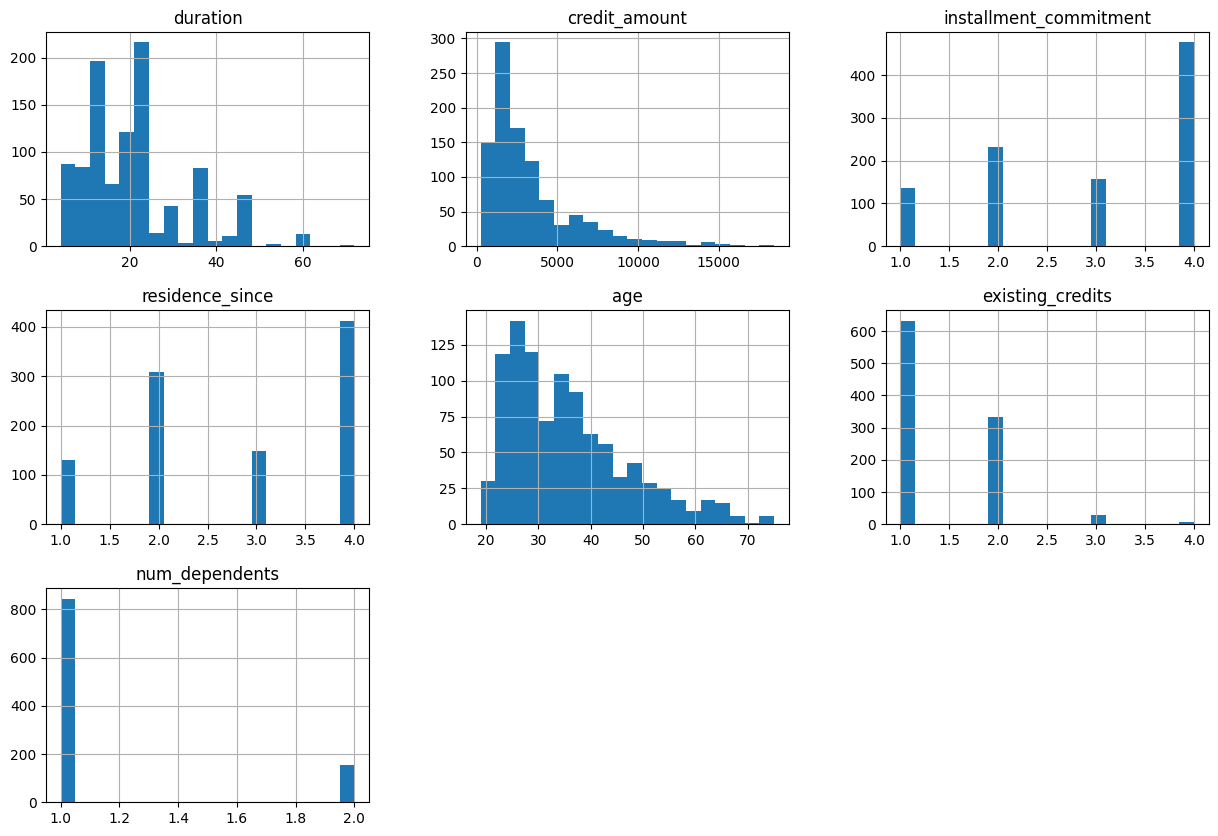

In [5]:
# Feature Distributions (Numeric Variables)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[num_cols].hist(bins=20, figsize=(15, 10))
plt.show()

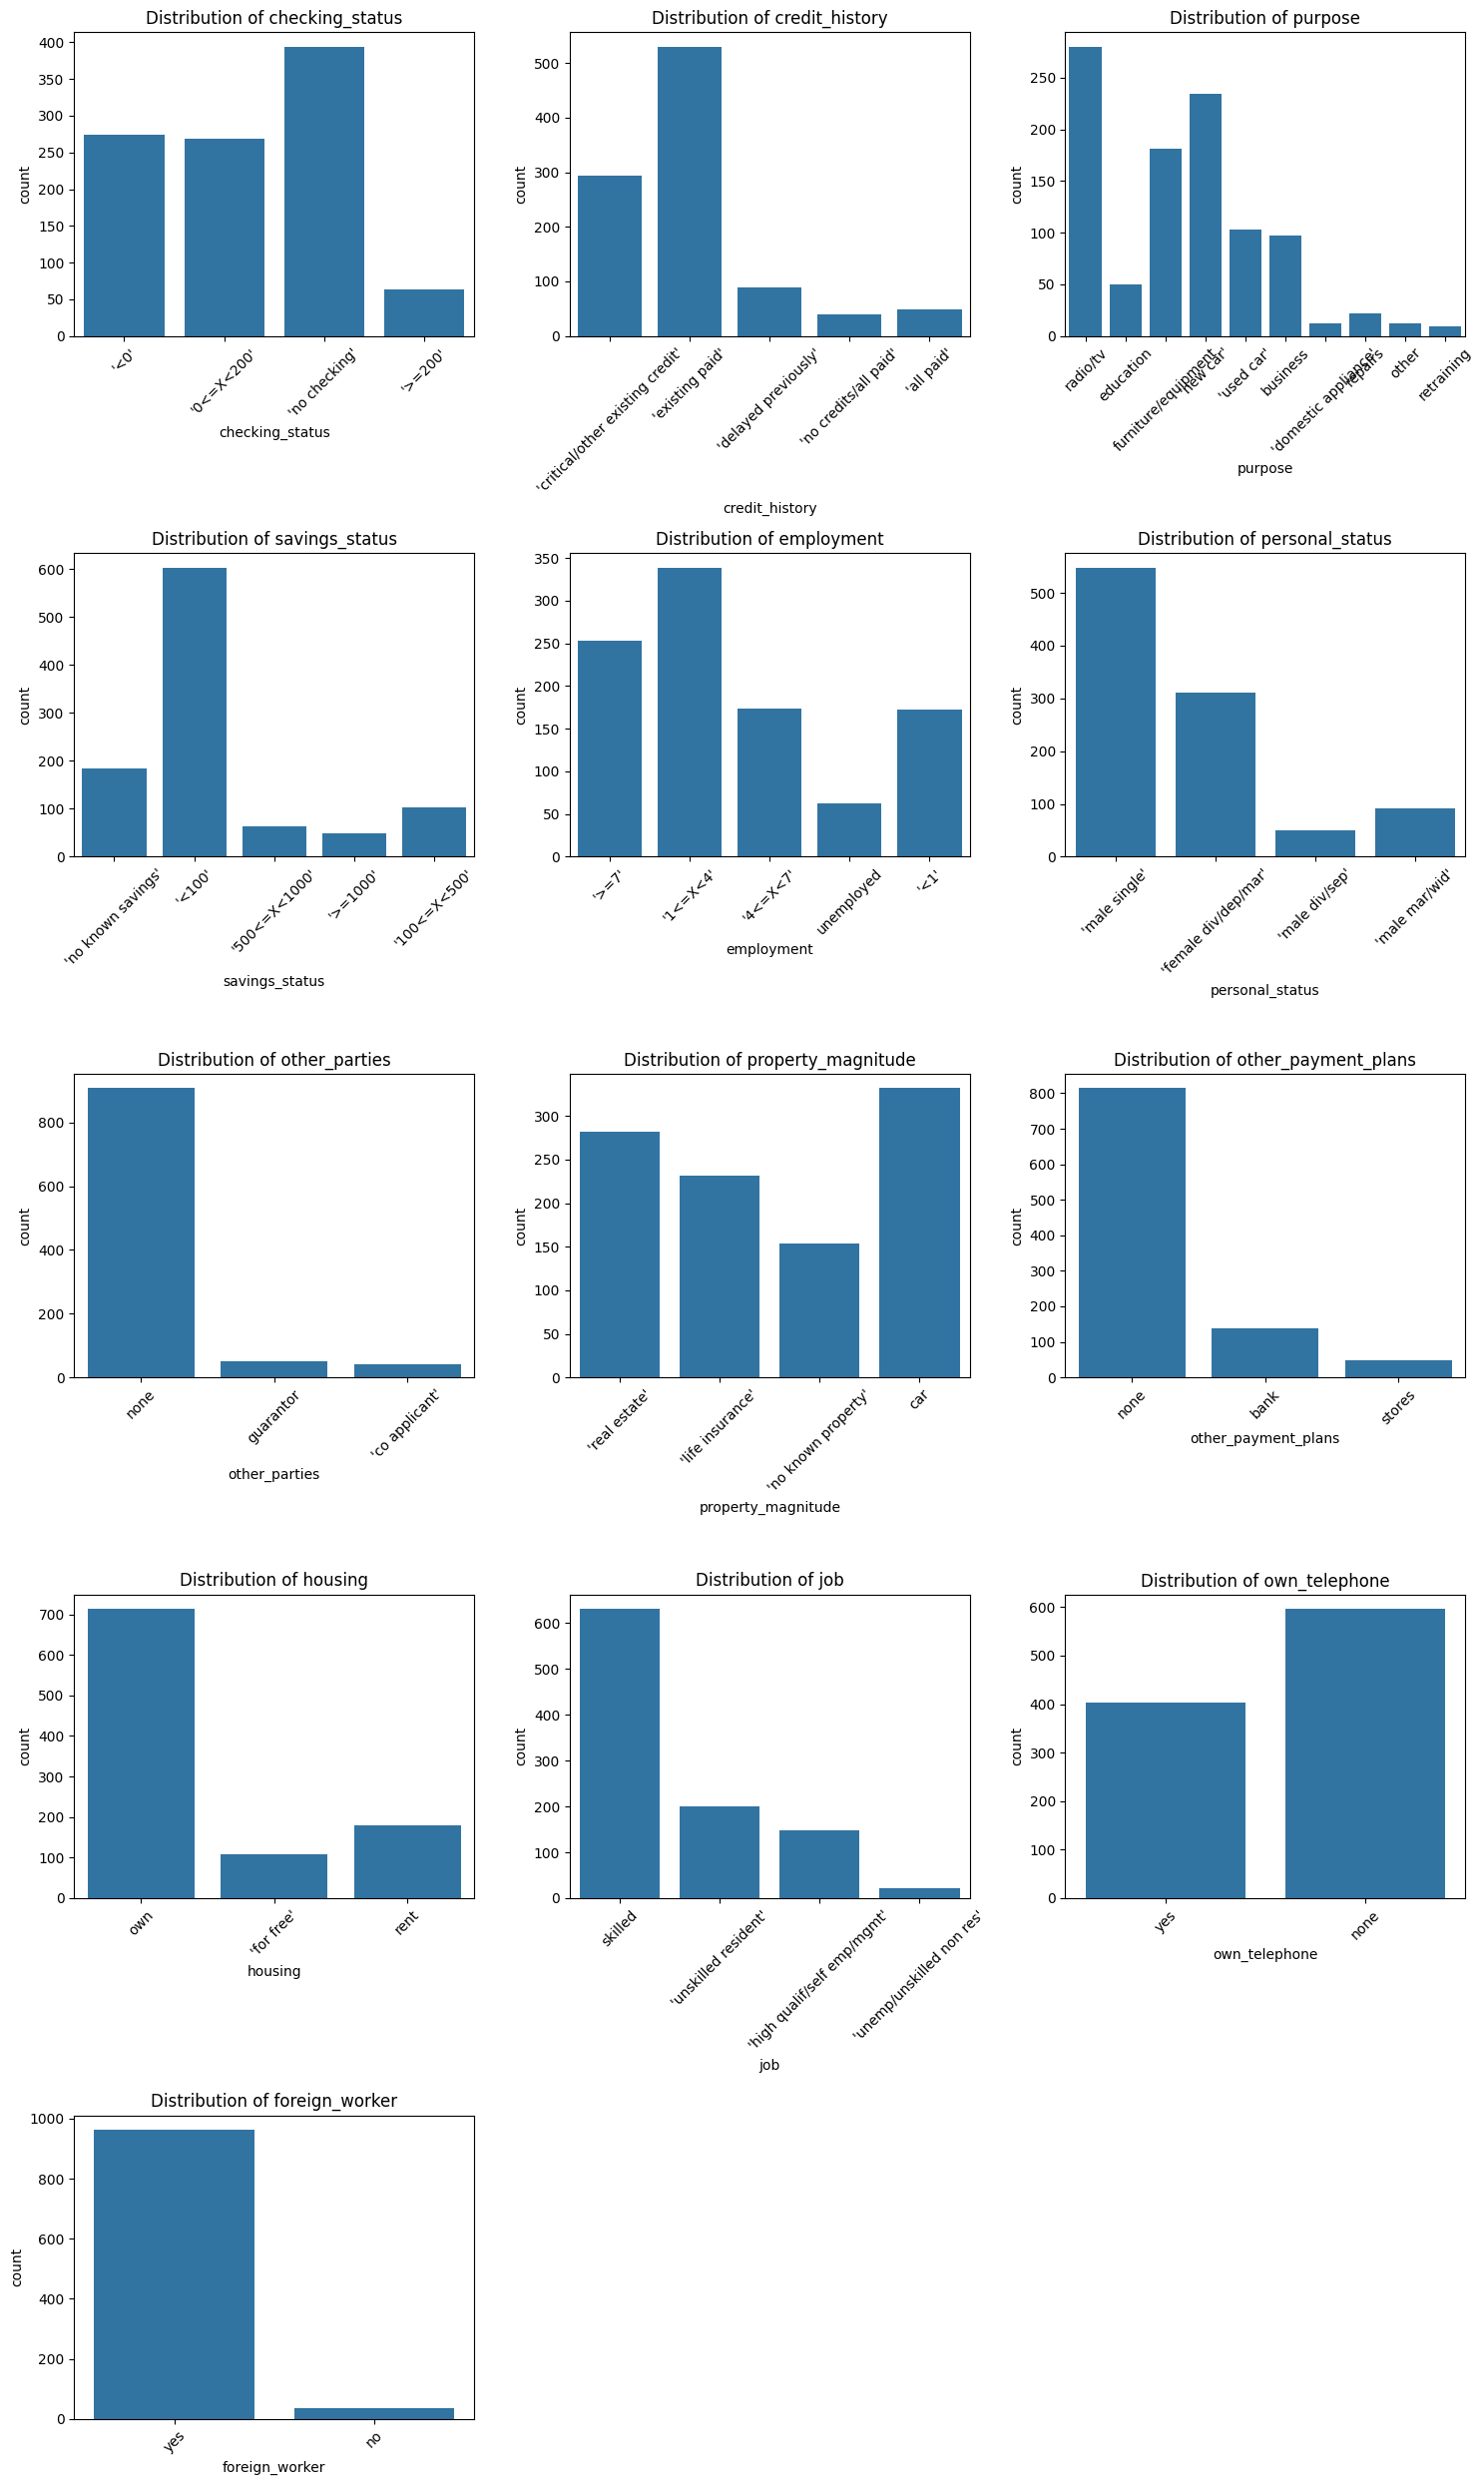

In [6]:
# Feature Distributions (Categorical Variables)

cat_cols = df.select_dtypes(include=['object', 'category']).columns.drop("class", errors='ignore')

n_cols = 3 
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

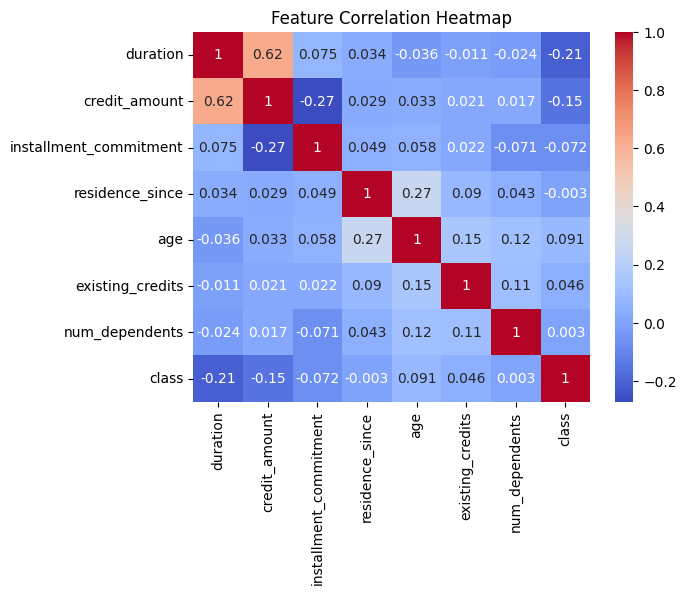

Correlation with Target:
 class                     1.000000
age                       0.091127
existing_credits          0.045732
num_dependents            0.003015
residence_since          -0.002967
installment_commitment   -0.072404
credit_amount            -0.154739
duration                 -0.214927
Name: class, dtype: float64


In [7]:
# Numerical correlation matrix:

# Convert categorical class coloumn to numeric
df["class"] = df["class"].map({"good": 1, "bad": 0})

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

corr = df[num_cols].corr()
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# Correlation with target
corr_with_target = corr["class"].sort_values(ascending=False)
print("Correlation with Target:\n", corr_with_target)

# Convert categorical class coloumn from numeric back to categorical
df["class"] = df["class"].map({1: "good", 0: "bad"})


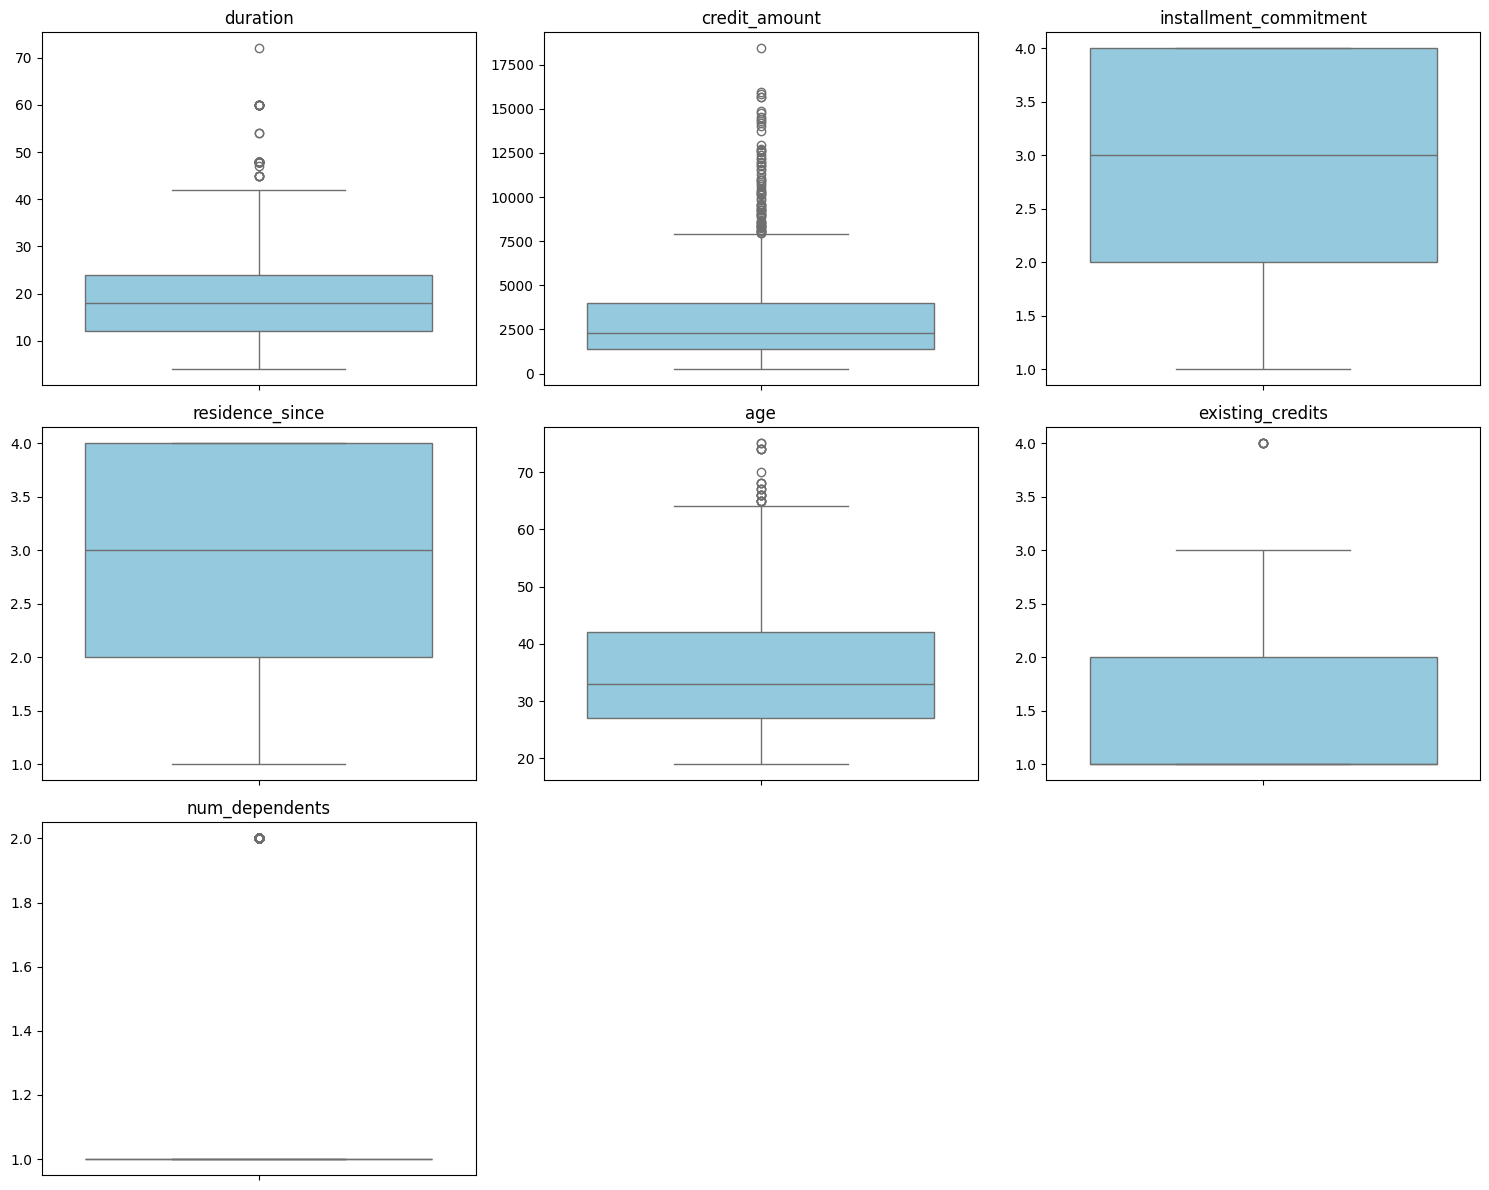

In [8]:
# Outlier Detection

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[i], color="skyblue")
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Summary

- Dataset has 1000 samples and 21 features.
- Target variable (class) is imbalanced (70% good, 30% bad).
- The most correlated features to "class" are: credit_amount and duration (excluding categorical features)
- Categorical variables may need encoding later
- Missing values not found

# Data preprocessing, normalization and data split

In [9]:
# Target column
target_col = "class"

# Encode target: good=1, bad=0
df[target_col] = df[target_col].map({"good": 1, "bad": 0})

# Separate features and target
x = df.drop(columns=[target_col])
y = df[target_col]

# Identify Categorical and Numerical Columns
num_cols = x.select_dtypes(include=['int64', 'float64']).columns
cat_cols = x.select_dtypes(include=['object', 'category']).columns


# Encode Categorical Variables
x_encoded = pd.get_dummies(x, columns=cat_cols, drop_first=True)
print(f"Shape before encoding: {x.shape}")
print(f"Shape after encoding: {x_encoded.shape}")

Shape before encoding: (1000, 20)
Shape after encoding: (1000, 48)


In [10]:
# Normalize Numerical Features
# mean=0, std=1

print("Duration before")
print(x_encoded["duration"].head())

scaler = StandardScaler()
x_encoded[num_cols] = scaler.fit_transform(x_encoded[num_cols])

print("Duration after")
print(x_encoded["duration"].head())

Duration before
0     6
1    48
2    12
3    42
4    24
Name: duration, dtype: int64
Duration after
0   -1.236478
1    2.248194
2   -0.738668
3    1.750384
4    0.256953
Name: duration, dtype: float64


In [11]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(
    x_encoded, y, test_size=0.15, random_state=42, stratify=y
)

print("Training samples:", x_train.shape[0])
print("Test samples:", x_test.shape[0])

Training samples: 850
Test samples: 150


In [12]:
# Check Class Imbalance

unique, counts = np.unique(y_train, return_counts=True)
print("Train class distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test class distribution:", dict(zip(unique, counts)))

Train class distribution: {np.int64(0): np.int64(255), np.int64(1): np.int64(595)}
Test class distribution: {np.int64(0): np.int64(45), np.int64(1): np.int64(105)}


##  Sumary

- Categorical variables encoded
- Numerical features normalized
- Train-test split is done
- No class imbalance

# Configuration

In [13]:
# Define Input dimensions 
input_dim = x_train.shape[1]
print("Input dimension:", input_dim)

Input dimension: 48


In [14]:
# Define MLP model
model = keras.Sequential([
    layers.Input(shape=(input_dim,)),                # Input layer
    layers.Dense(64, activation='relu'),             # Hidden layer 1
    layers.Dense(16, activation='relu'),             # Hidden layer 2
    layers.Dense(1, activation='sigmoid')            # Output layer for binary classification
])


In [15]:
# Compile the Model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',  
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')]
)

In [16]:
# Model Summart
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,193 (16.38 KB)

 Trainable params: 4,193 (16.38 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), # stop training early
]

In [18]:
# Train the model
history = model.fit(
    x_train, y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6330 - auc: 0.5448 - loss: 0.6502 - precision: 0.7285 - recall: 0.7642 - val_accuracy: 0.6953 - val_auc: 0.6019 - val_loss: 0.6141 - val_precision: 0.6880 - val_recall: 1.0000
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7285 - auc: 0.7717 - loss: 0.5338 - precision: 0.7312 - recall: 0.9725 - val_accuracy: 0.6719 - val_auc: 0.7032 - val_loss: 0.5795 - val_precision: 0.6864 - val_recall: 0.9419
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7576 - auc: 0.8103 - loss: 0.4878 - precision: 0.7634 - recall: 0.9509 - val_accuracy: 0.6953 - val_auc: 0.7461 - val_loss: 0.5473 - val_precision: 0.7374 - val_recall: 0.8488
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7867 - auc: 0.8278 - loss: 0.4614 - precision: 0.7983 - recall: 0.9332 - val_accuracy: 0.7344 - val_auc: 0.7705 - val_loss: 0.5298 - val_precision: 0.7653 - val_recall: 0.8721
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━

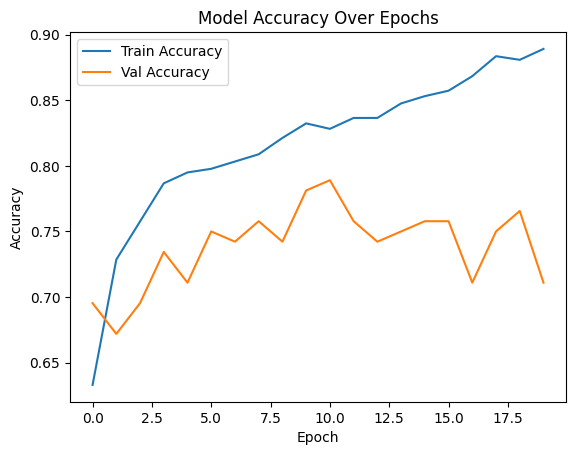

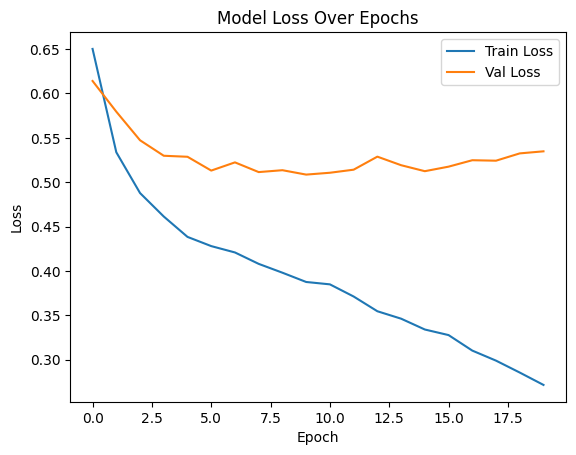

In [19]:
# Visualize
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Experiment Tracking

In [20]:
# Initialize experiment log
experiment_log = pd.DataFrame(columns=[
    "Experiment", "Architecture", "Optimizer", "Learning Rate", "Batch Size",
    "Epochs", "Dropout", "BatchNorm", "Train Accuracy", "Val Accuracy",
    "Train Loss", "Val Loss", "Test Accuracy", "Test Loss", "Precision", "Recall", "AUC"
])

experiment_log.to_csv("experiment_log.csv", index=False)

In [21]:
# Experiment definition
def run_experiment(name, hidden_layers=[64,16], optimizer="Adam", optimizer_lr=0.001, batch_size=16, epochs=100, dropout_rate=0.0, batch_norm=False):
    
    model_layers = [layers.Input(shape=(input_dim,))] # input layer
    
    for neurons in hidden_layers: # hidden layers
        model_layers.append(layers.Dense(neurons, activation='relu'))
        if batch_norm:
            model_layers.append(layers.BatchNormalization())
        if dropout_rate > 0:
            model_layers.append(layers.Dropout(dropout_rate))
    
    model_layers.append(layers.Dense(1, activation='sigmoid')) # output layer
    
    model = keras.Sequential(model_layers) 
    
    if optimizer == "Adam":
        opt_function = keras.optimizers.Adam(learning_rate=optimizer_lr)
    elif optimizer == "SGD": 
        opt_function = keras.optimizers.SGD(learning_rate=optimizer_lr, momentum=0.9)

    model.compile(
        optimizer=opt_function,
        loss='binary_crossentropy',
        metrics=['accuracy',  
            tf.keras.metrics.Precision(name='precision'), # out of all customers the model said were "good" (approved loans), how many were actually good payers?
            tf.keras.metrics.Recall(name='recall'), # out of all actual "good" customers, how many did the model correctly approve?
            tf.keras.metrics.AUC(name='auc')], # how well the model separates the two classes (0.5 -> random guessing, 0.9+ -> excellent)
    )
    
    # Callbacks
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    
    history = model.fit(
        x_train, y_train,
        validation_split=0.15,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0
    )
    
    # Evaluate on test set
    test_results = model.evaluate(x_test, y_test, verbose=0)
    
    # Log experiment
    experiment_log.loc[len(experiment_log)] = [
        name,
        str(hidden_layers),
        optimizer,
        optimizer_lr,
        batch_size,
        len(history.history['loss']),
        dropout_rate,
        batch_norm,
        history.history['accuracy'][-1],
        history.history['val_accuracy'][-1],
        history.history['loss'][-1],
        history.history['val_loss'][-1],
        test_results[1],   # test accuracy
        test_results[0],   # test loss
        history.history['precision'][-1],
        history.history['recall'][-1],
        history.history['auc'][-1],
    ]
    
    return model, history


In [22]:
baseline_model, baseline_history = run_experiment(
    name="Baseline"
)

experiment_log[experiment_log['Experiment'] == 'Baseline']


,Experiment,Architecture,Optimizer,Learning Rate,Batch Size,Epochs,Dropout,BatchNorm,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Test Accuracy,Test Loss,Precision,Recall,AUC
0,Baseline,"[64, 16]",Adam,0.001,16,16,0.0,False,0.864266,0.757812,0.301114,0.523485,0.74,0.518346,0.882682,0.931238,0.936689


# Experiments

In the base line experiment train accuracy is segnificantly higher than val accuracy witch means overfitting

To prevent overfitting we can try adding droput

Dropout randomly deactivates neurons during training to prevent over-reliance on specific nodes, witch prevents overfitting

In [23]:

model, history = run_experiment(
    name="Dropout",
    dropout_rate=0.25
)

experiment_log[experiment_log['Experiment'] == 'Dropout']


,Experiment,Architecture,Optimizer,Learning Rate,Batch Size,Epochs,Dropout,BatchNorm,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Test Accuracy,Test Loss,Precision,Recall,AUC
1,Dropout,"[64, 16]",Adam,0.001,16,21,0.25,False,0.807479,0.765625,0.40304,0.507581,0.753333,0.50503,0.840074,0.897839,0.869112


After running this experiment the gap between train accuracy and vall accuracy is lower, with val accuracy being a little higher than before

Dropout helped reduce overfitting as intended

AUC is slightly reduced witch means model’s ability to distinguish good vs bad declined slightly.
But the result is still good 

Next I'll try to add normalization layers to see if the result imroves

In [34]:
model, history = run_experiment(
    name="Dropout + Normalization",
    dropout_rate=0.25,
    batch_norm=True
)

experiment_log[experiment_log['Experiment'] == 'Dropout + Normalization']

,Experiment,Architecture,Optimizer,Learning Rate,Batch Size,Epochs,Dropout,BatchNorm,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Test Accuracy,Test Loss,Precision,Recall,AUC
2,Dropout + Normalization,"[64, 16]",Adam,0.001,16,45,0.25,True,0.891967,0.8125,0.269686,0.519183,0.746667,0.527073,0.915222,0.933202,0.948039


The models overfitting has worsen I dsmiss this change and try adding another layer instead 

In [35]:
model, history = run_experiment(
    name="Dropout + Deeper Network",
    dropout_rate=0.25,
    hidden_layers=[128, 64, 16],
)

experiment_log[experiment_log['Experiment'] == 'Dropout + Deeper Network']

,Experiment,Architecture,Optimizer,Learning Rate,Batch Size,Epochs,Dropout,BatchNorm,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Test Accuracy,Test Loss,Precision,Recall,AUC
3,Dropout + Deeper Network,"[128, 64, 16]",Adam,0.001,16,18,0.25,False,0.862881,0.75,0.327565,0.537656,0.74,0.513292,0.888258,0.921415,0.915465


Again the overfitting is worse for rthis arvhetecture. I'll try bottle neck technic with the same number of layers 

In [36]:
model, history = run_experiment(
    name="Dropout + Bottleneck",
    dropout_rate=0.25,
    hidden_layers=[128, 32, 128],
)

experiment_log[experiment_log['Experiment'] == 'Dropout + Bottleneck']

,Experiment,Architecture,Optimizer,Learning Rate,Batch Size,Epochs,Dropout,BatchNorm,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Test Accuracy,Test Loss,Precision,Recall,AUC
4,Dropout + Bottleneck,"[128, 32, 128]",Adam,0.001,16,17,0.25,False,0.871191,0.75,0.301603,0.592889,0.733333,0.51693,0.88806,0.935167,0.927267


The overfitting is worse so I'll try to run it with normalization and if it doesnt work I'll dismiss the changes

In [37]:
model, history = run_experiment(
    name="Dropout + Bottleneck + Normalization",
    dropout_rate=0.25,
    batch_norm=True,
    hidden_layers=[128, 32, 128],
)

experiment_log[experiment_log['Experiment'] == 'Dropout + Bottleneck + Normalization']

,Experiment,Architecture,Optimizer,Learning Rate,Batch Size,Epochs,Dropout,BatchNorm,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Test Accuracy,Test Loss,Precision,Recall,AUC
5,Dropout + Bottleneck + Normalization,"[128, 32, 128]",Adam,0.001,16,29,0.25,True,0.847645,0.734375,0.322697,0.572922,0.733333,0.576181,0.874296,0.915521,0.919178


The accuracy is now lower, so the best experiments were with only dropout added

I'll focus on the network with dropout and try to adjust hyperparameters with hyperparameters search 

In [38]:
# Save to csv
experiment_log.to_csv("experiment_log.csv", index=False)

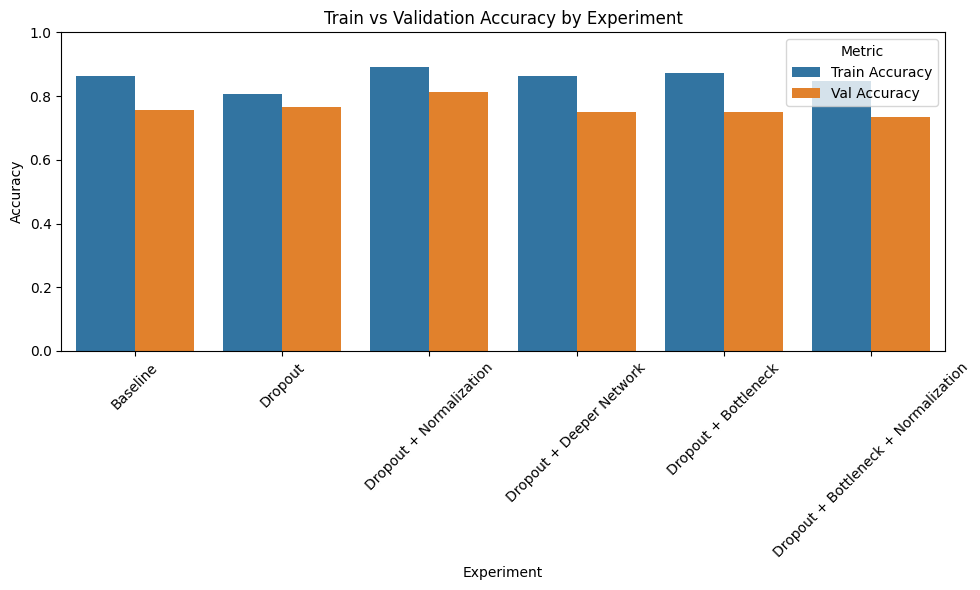

In [39]:
# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=experiment_log.melt(id_vars='Experiment', value_vars=['Train Accuracy', 'Val Accuracy']),
            x='Experiment', y='value', hue='variable')

plt.title('Train vs Validation Accuracy by Experiment')
plt.ylabel('Accuracy')
plt.xlabel('Experiment')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Hyperparameter search (random)

In [41]:
# Reset experiment log
experiment_log = pd.DataFrame(columns=[
    "Experiment", "Architecture", "Optimizer", "Learning Rate", "Batch Size",
    "Epochs", "Dropout", "BatchNorm", "Train Accuracy", "Val Accuracy",
    "Train Loss", "Val Loss", "Test Accuracy", "Test Loss",
    "Precision", "Recall", "AUC"
])


In [43]:
import random

# Define search space
param_space = {
    "optimizer": ["Adam", "SGD"],
    "optimizer_lr": [0.1, 0.01, 0.001, 0.0001, 0.00001],
    "batch_size": [8, 16, 32, 64],
    "dropout_rate": [0.20, 0.25, 0.30],
    "batch_norm": [True, False],
    "hidden_layers": [
        [64,16], 
        [128, 32, 128], 
        [64,32],
        [64,64], 
        [32,32,32], 
        [64,64,64],
        [128, 64, 32],
        [128, 64, 32, 16]
    ],
}

def random_search(n_experiments=50):
    for i in range(n_experiments):
        params = {
            "optimizer": random.choice(param_space["optimizer"]),
            "optimizer_lr": random.choice(param_space["optimizer_lr"]),
            "batch_size": random.choice(param_space["batch_size"]),
            "dropout_rate": random.choice(param_space["dropout_rate"]),
            "batch_norm": random.choice(param_space["batch_norm"]),
            "hidden_layers": random.choice(param_space["hidden_layers"]),
        }

        exp_name = i+1
        print(f"\nRunning {i+1}/{n_experiments} experiment with params: {params}")

        model, history = run_experiment(
            name=exp_name,
            optimizer=params["optimizer"],
            optimizer_lr=params["optimizer_lr"],
            batch_size=params["batch_size"],
            dropout_rate=params["dropout_rate"],
            batch_norm=params["batch_norm"],
            hidden_layers=params["hidden_layers"]
        )


In [45]:
random_search(n_experiments=50)


Running 1/50 experiment with params: {'optimizer': 'SGD', 'optimizer_lr': 0.01, 'batch_size': 32, 'dropout_rate': 0.2, 'batch_norm': True, 'hidden_layers': [128, 32, 128]}

Running 2/50 experiment with params: {'optimizer': 'SGD', 'optimizer_lr': 0.01, 'batch_size': 8, 'dropout_rate': 0.2, 'batch_norm': False, 'hidden_layers': [64, 64]}

Running 3/50 experiment with params: {'optimizer': 'Adam', 'optimizer_lr': 0.1, 'batch_size': 16, 'dropout_rate': 0.25, 'batch_norm': True, 'hidden_layers': [64, 64, 64]}

Running 4/50 experiment with params: {'optimizer': 'SGD', 'optimizer_lr': 0.1, 'batch_size': 16, 'dropout_rate': 0.2, 'batch_norm': False, 'hidden_layers': [128, 64, 32, 16]}

Running 5/50 experiment with params: {'optimizer': 'SGD', 'optimizer_lr': 0.01, 'batch_size': 32, 'dropout_rate': 0.25, 'batch_norm': False, 'hidden_layers': [64, 32]}

Running 6/50 experiment with params: {'optimizer': 'SGD', 'optimizer_lr': 0.01, 'batch_size': 64, 'dropout_rate': 0.25, 'batch_norm': True, 'h

In [48]:
experiment_log.sort_values(by="Val Accuracy", ascending=False).head(10)

,Experiment,Architecture,Optimizer,Learning Rate,Batch Size,Epochs,Dropout,BatchNorm,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Test Accuracy,Test Loss,Precision,Recall,AUC
22,18,"[128, 64, 32]",SGD,0.0100,64,48,0.30,False,0.826870,0.796875,0.388855,0.470073,0.733333,0.520991,0.840426,0.931238,0.880282
12,8,"[64, 64]",Adam,0.0010,32,27,0.25,False,0.847645,0.789062,0.343929,0.514050,0.746667,0.513076,0.862069,0.933202,0.908437
0,1,"[128, 64, 32]",SGD,0.0010,32,100,0.20,False,0.786704,0.789062,0.443204,0.473750,0.746667,0.528239,0.819820,0.893910,0.836686
16,12,"[64, 64]",Adam,0.0010,64,30,0.25,False,0.826870,0.789062,0.372398,0.479082,0.733333,0.538673,0.850365,0.915521,0.887370
54,50,"[128, 64, 32]",Adam,0.0100,32,22,0.30,True,0.897507,0.789062,0.262280,0.646204,0.726667,0.543076,0.915870,0.941061,0.946231
44,40,"[64, 64, 64]",SGD,0.0100,64,29,0.20,True,0.890582,0.789062,0.266393,0.559580,0.760000,0.528205,0.905660,0.943026,0.949334
43,39,"[64, 16]",SGD,0.1000,16,14,0.20,False,0.801939,0.781250,0.405567,0.579161,0.733333,0.501739,0.821053,0.919450,0.858781
25,21,"[64, 16]",Adam,0.0001,16,100,0.20,False,0.800554,0.773438,0.440996,0.484164,0.700000,0.525600,0.823009,0.913556,0.834108
34,30,"[32, 32, 32]",Adam,0.0010,32,52,0.30,True,0.829640,0.773438,0.373164,0.528179,0.700000,0.560657,0.844643,0.929273,0.883579
30,26,"[128, 64, 32, 16]",SGD,0.0010,32,72,0.25,True,0.825485,0.773438,0.403433,0.476299,0.720000,0.557871,0.840142,0.929273,0.859533


The best result has Val Accuracy of 79.6% Train Accurecy of 82.6% and AUC of 88%
- Val Accuracy is big
- Gap between train and val accuracy is small
- AUC is big witch means the model distinguishes classes good enough

When looking at test accuracy we can confirm that this is one of the bet models (73.3%)

The best model has following hyperparams:
- Architecture: [128, 64, 32]
- Optimizer: SGD
- Learning Rate: 0.01
- Batch Size: 64
- Dropout: 0.30
- BatchNorm: False

# Results & Evaluation Metrics

In [61]:
experiment_log = experiment_log[experiment_log['Experiment'] != 'Best Model']

In [62]:
best_model, best_history = run_experiment(
    name="Best Model",
    hidden_layers=[128, 64, 32],
    optimizer="SGD",
    optimizer_lr=0.01,
    batch_size=64,
    dropout_rate=0.30,
    batch_norm=False
)

experiment_log[experiment_log['Experiment'] == 'Best Model']

,Experiment,Architecture,Optimizer,Learning Rate,Batch Size,Epochs,Dropout,BatchNorm,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Test Accuracy,Test Loss,Precision,Recall,AUC
55,Best Model,"[128, 64, 32]",SGD,0.01,64,41,0.3,False,0.82133,0.757812,0.402196,0.500058,0.74,0.50854,0.83101,0.937132,0.874858


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Classification Report:
              precision    recall  f1-score   support

           0      0.571     0.533     0.552        45
           1      0.806     0.829     0.817       105

    accuracy                          0.740       150
   macro avg      0.688     0.681     0.684       150
weighted avg      0.735     0.740     0.737       150



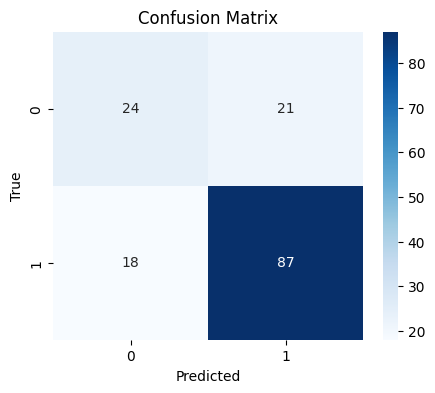

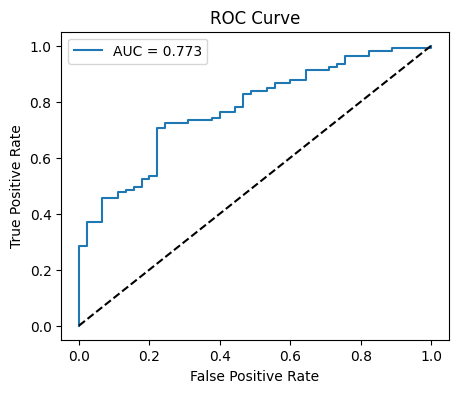

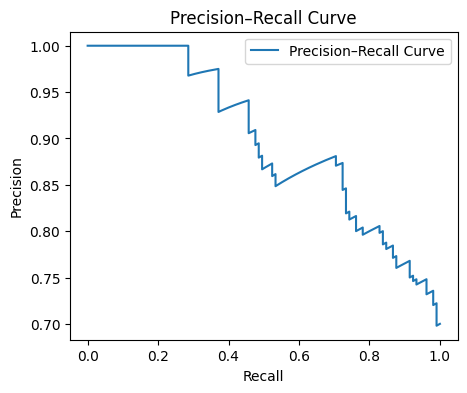

In [69]:
# Results and Evaluation Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Predict probabilities and classes
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, label="Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()